In [ ]:
# Forcing autoreload of modules so restart is not required
%load_ext autoreload
%autoreload 2

import os

os.chdir("../../")


print("Current Working Directory:  ", os.getcwd())

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import WeightedRandomSampler, DataLoader
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('./data/processed/NSL_KDD/multi_class/X_train.csv',low_memory=False)
Y_train = pd.read_csv('./data/processed/NSL_KDD/multi_class/Y_train.csv',low_memory=False)


X_test = pd.read_csv('./data/processed/NSL_KDD/multi_class/X_test.csv',low_memory=False)
Y_test = pd.read_csv('./data/processed/NSL_KDD/multi_class/Y_test.csv',low_memory=False)

In [4]:
print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", Y_test.shape)

X_train:  (125973, 123)
Y_train:  (125973, 1)
X_test:  (22544, 123)
y_test:  (22544, 1)


In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long).squeeze()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long).squeeze()

In [6]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Classifier(nn.Module):
	def __init__(self, input_size=123, hidden_size=256, num_classes=3):
		super(Classifier, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size)
		self.bn1 = nn.BatchNorm1d(hidden_size)
		self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
		self.bn2 = nn.BatchNorm1d(hidden_size // 2)
		self.fc3 = nn.Linear(hidden_size // 2, num_classes)
		self.relu = nn.ReLU()
	
	def forward(self, x):
		out = self.fc1(x)
		out = self.bn1(out)
		out = self.relu(out)
		out = self.fc2(out)
		out = self.bn2(out)
		out = self.relu(out)
		out = self.fc3(out)
		return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50
loss_history = []
for epoch in range(num_epochs):
	model.train()
	running_loss = 0.0
	for i, (inputs, labels) in enumerate(train_loader):
		inputs, labels = inputs.to(device), labels.to(device)
		
		outputs = model(inputs)
		loss = criterion(outputs, labels)
		
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		running_loss += loss.item()
	avg_loss = running_loss / len(train_loader)
	loss_history.append(avg_loss)
	print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/50], Loss: 0.0264
Epoch [2/50], Loss: 0.0093
Epoch [3/50], Loss: 0.0069
Epoch [4/50], Loss: 0.0059
Epoch [5/50], Loss: 0.0048
Epoch [6/50], Loss: 0.0062
Epoch [7/50], Loss: 0.0043
Epoch [8/50], Loss: 0.0045
Epoch [9/50], Loss: 0.0037
Epoch [10/50], Loss: 0.0038
Epoch [11/50], Loss: 0.0034
Epoch [12/50], Loss: 0.0036
Epoch [13/50], Loss: 0.0032
Epoch [14/50], Loss: 0.0029
Epoch [15/50], Loss: 0.0032
Epoch [16/50], Loss: 0.0023
Epoch [17/50], Loss: 0.0026
Epoch [18/50], Loss: 0.0025
Epoch [19/50], Loss: 0.0025
Epoch [20/50], Loss: 0.0021
Epoch [21/50], Loss: 0.0025
Epoch [22/50], Loss: 0.0021
Epoch [23/50], Loss: 0.0020
Epoch [24/50], Loss: 0.0022
Epoch [25/50], Loss: 0.0021
Epoch [26/50], Loss: 0.0021
Epoch [27/50], Loss: 0.0019
Epoch [28/50], Loss: 0.0018
Epoch [29/50], Loss: 0.0018
Epoch [30/50], Loss: 0.0018
Epoch [31/50], Loss: 0.0019
Epoch [32/50], Loss: 0.0022
Epoch [33/50], Loss: 0.0018
Epoch [34/50], Loss: 0.0016
Epoch [35/50], Loss: 0.0016
Epoch [36/50], Loss: 0.0016
E

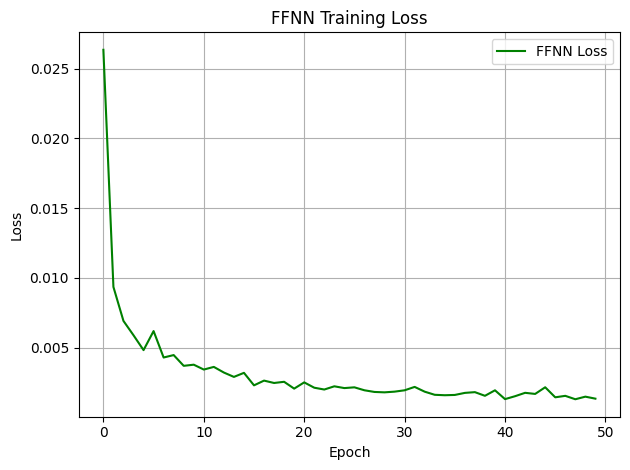

In [11]:
plt.plot(loss_history, label='FFNN Loss', color='green')
plt.title("FFNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from tabulate import tabulate
def evaluate(model, test_loader):
	model.eval()
	all_preds = []
	all_labels = []
	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs, labels = inputs.to(device).float(), labels.to(device).squeeze().long()
			outputs = model(inputs)
			_, predicted = torch.max(outputs.data, 1)

			all_preds.extend(predicted.cpu().numpy())
			all_labels.extend(labels.cpu().numpy())
	accuracy = 100 * sum([1 for p, l in zip(all_preds, all_labels) if p == l]) / len(all_labels)
	report = classification_report(all_labels, all_preds, target_names=['0', '1','2'], output_dict=True)

	headers = ['precision', 'recall', 'f1-score', 'support']
	table_data = []

	for label in ['0', '1','2']:
		row = [f"{report[label][metric]:.2f}" for metric in headers[:-1]]
		row.append(int(report[label]['support']))
		table_data.append([label] + row)

	table_data.append(['accuracy', '', '', f"{report['accuracy']:.2f}", len(all_labels)])
	table_data.append(['macro avg'] + [f"{report['macro avg'][metric]:.2f}" for metric in headers[:-1]] + [int(report['macro avg']['support'])])
	table_data.append(['weighted avg'] + [f"{report['weighted avg'][metric]:.2f}" for metric in headers[:-1]] + [int(report['weighted avg']['support'])])

	print(f"Test Accuracy: {accuracy/100:.4f}")
	print("Classification Report:")
	print(tabulate(table_data, headers=[''] + headers, tablefmt='grid', floatfmt='.2f'))

	report = classification_report(all_labels, all_preds, target_names=['0', '1','2'], output_dict=True)
	return report

Test Accuracy: 0.8021
Classification Report:
+--------------+-------------+----------+------------+-----------+
|              | precision   | recall   |   f1-score |   support |
+==============+=============+==========+============+===========+
| 0            | 0.76        | 0.96     |       0.85 |      9711 |
+--------------+-------------+----------+------------+-----------+
| 1            | 0.83        | 1.00     |       0.90 |      5741 |
+--------------+-------------+----------+------------+-----------+
| 2            | 0.90        | 0.42     |       0.58 |      7092 |
+--------------+-------------+----------+------------+-----------+
| accuracy     |             |          |       0.80 |     22544 |
+--------------+-------------+----------+------------+-----------+
| macro avg    | 0.83        | 0.79     |       0.78 |     22544 |
+--------------+-------------+----------+------------+-----------+
| weighted avg | 0.82        | 0.80     |       0.78 |     22544 |
+--------------+-

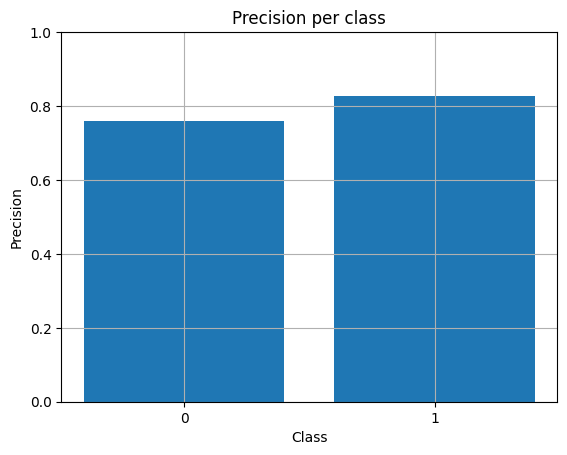

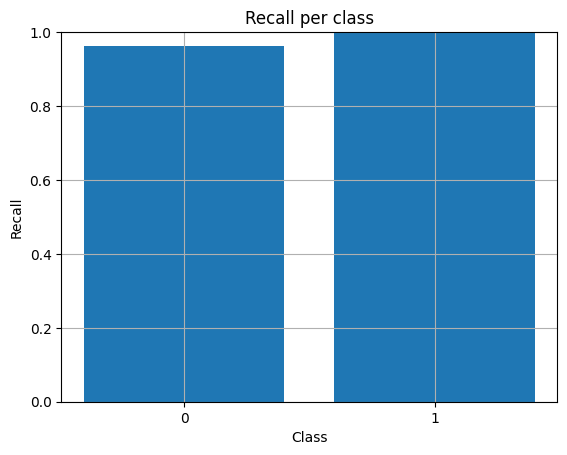

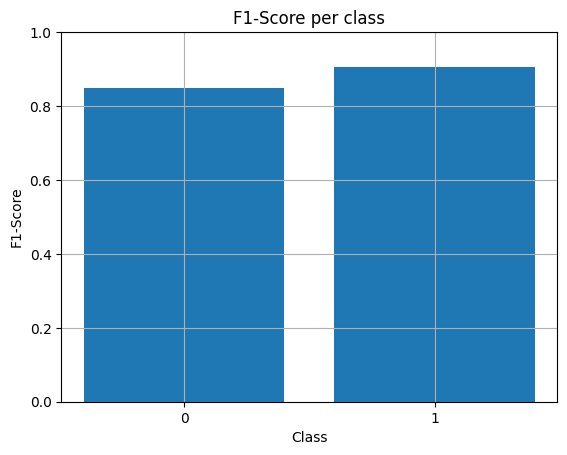

In [ ]:
report = evaluate(model, test_loader)
metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']

for metric in metrics:
	values = [report[cls][metric] for cls in classes]
	plt.bar(classes, values)
	plt.ylim(0, 1)
	plt.title(f"{metric.title()} per class")
	plt.xlabel("Class")
	plt.ylabel(metric.title())
	plt.grid(True)
	plt.show()

### XGBOOST ALONE

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# %%
best_params_model1 = xgb.XGBClassifier(
	objective='binary:logistic',
	eval_metric='mlogloss',
	use_label_encoder=False,
	random_state=42,
	n_jobs=-1,
	colsample_bytree=np.float64(0.7159005811655073),
	gamma=np.float64(0.08061064362700221),
	learning_rate=np.float64(0.19593953046851464),
	max_depth=7,
	min_child_weight=1,
	n_estimators=233,
	reg_alpha=np.float64(0.22826728524145512),
	reg_lambda=np.float64(0.2965963934951502),
	subsample=np.float64(0.7666039791481465)
)

best_params_model1.fit(X_train, Y_train)

# Predict and evaluate
y_pred_feat1 = best_params_model1.predict(X_test)

print("Test Set Accuracy (XGBoost):", accuracy_score(Y_test, y_pred_feat1))
print("Classification Report (XGBoost):")
print(classification_report(Y_test, y_pred_feat1, digits=2))

/home/adrian/UARK/Spring_2025/NetworkSecurity/project/code/.venv/lib64/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:18:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Set Accuracy (XGBoost): 0.7980837473385379
Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      9711
           1       0.89      1.00      0.94      5741
           2       0.93      0.40      0.56      7092

    accuracy                           0.80     22544
   macro avg       0.85      0.79      0.78     22544
weighted avg       0.83      0.80      0.77     22544



### XGBOOST + FNN

In [ ]:
# %%
def extract_features(model, loader):
	model.eval()
	features = []
	labels = []
	with torch.no_grad():
		for inputs, lbls in loader:
			inputs = inputs.to(device)
			# Forward pass up to second-to-last layer
			x = model.fc1(inputs)
			x = model.bn1(x)
			x = model.relu(x)
			x = model.fc2(x)
			x = model.bn2(x)
			x = model.relu(x)
			
			features.append(x.cpu().numpy())
			labels.extend(lbls.numpy())
	return np.vstack(features), np.array(labels)

# Extract features from both train and test sets
X_train_feat, y_train_feat = extract_features(model, train_loader)
X_test_feat, y_test_feat = extract_features(model, test_loader)

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# %%
best_params_model = xgb.XGBClassifier(
	objective='multi:softprob',
	num_class=3,
	eval_metric='mlogloss',
	use_label_encoder=False,
	random_state=42,
	n_jobs=-1,
	colsample_bytree=np.float64(0.7159005811655073),
	gamma=np.float64(0.08061064362700221),
	learning_rate=np.float64(0.19593953046851464),
	max_depth=7,
	min_child_weight=1,
	n_estimators=233,
	reg_alpha=np.float64(0.22826728524145512),
	reg_lambda=np.float64(0.2965963934951502),
	subsample=np.float64(0.7666039791481465)
)

best_params_model.fit(X_train_feat, y_train_feat)

# Predict and evaluate
y_pred_feat = best_params_model.predict(X_test_feat)

print("Test Set Accuracy (FFNN + XGBoost):", accuracy_score(y_test_feat, y_pred_feat))
print("Classification Report (FFNN + XGBoost):")
print(classification_report(y_test_feat, y_pred_feat, digits=3))

/home/adrian/UARK/Spring_2025/NetworkSecurity/project/code/.venv/lib64/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:18:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Set Accuracy (FFNN + XGBoost): 0.8117015613910575
Classification Report (FFNN + XGBoost):
              precision    recall  f1-score   support

           0      0.767     0.958     0.852      9711
           1      0.845     0.997     0.914      5741
           2      0.899     0.462     0.610      7092

    accuracy                          0.812     22544
   macro avg      0.837     0.805     0.792     22544
weighted avg      0.828     0.812     0.792     22544

